In [1]:
from pathlib import Path
import sys

sys.path.append(str(Path().resolve().parent))
import os

os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
from pathlib import Path
import numpy as np
from quri_parts.core.estimator.gradient import (
    create_numerical_gradient_estimator,
)
from quri_parts.qulacs.estimator import (
    create_qulacs_vector_concurrent_estimator,
    create_qulacs_vector_concurrent_parametric_estimator,
)
from quri_parts.algo.optimizer import Adam

In [3]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
x = df.loc[:, ["petal length (cm)", "petal width (cm)"]]
x_train, x_test, y_train, y_test = train_test_split(x, iris.target, test_size=0.25, random_state=0)

x_train = x_train.to_numpy()

from quri_parts.circuit.utils.circuit_drawer import draw_circuit
import matplotlib.pyplot as plt

n_qubits = 5
num_class = 3

In [4]:
from scikit_quri.circuit import create_qcl_ansatz

circuit = create_qcl_ansatz(n_qubits, 3, 1.0)
draw_circuit(circuit.circuit)
print(circuit.circuit.parameter_count)

   ___     ___     ___     ___     ___     ___     ___     ___     ___     ___  
  |PRY|   |PRZ|   |Mat|   |PRX|   |PRZ|   |PRX|   |Mat|   |PRX|   |PRZ|   |PRX| 
--|0  |---|1  |---|10 |---|11 |---|12 |---|13 |---|26 |---|27 |---|28 |---|29 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    ___     ___     ___    |   |    ___     ___     ___  
  |PRY|   |PRZ|   |   |   |PRX|   |PRZ|   |PRX|   |   |   |PRX|   |PRZ|   |PRX| 
--|2  |---|3  |---|   |---|14 |---|15 |---|16 |---|   |---|30 |---|31 |---|32 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    ___     ___     ___    |   |    ___     ___     ___  
  |PRY|   |PRZ|   |   |   |PRX|   |PRZ|   |PRX|   |   |   |PRX|   |PRZ|   |PRX| 
--|4  |---|5  |---|   |---|17 |---|18 |---|19 |---|   |---|33 |---|34 |---|35 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    _

In [5]:
from quri_parts.core.state import quantum_state

param_circuit_state = quantum_state(n_qubits=5, circuit=circuit.circuit)
init_params = [np.random.rand() for _ in range(circuit.learning_params_count)]
params = circuit.generate_bound_params(x_train[0], init_params)
circuit_state = param_circuit_state.bind_parameters(params)

from quri_parts.qulacs.estimator import create_qulacs_vector_estimator
from quri_parts.core.operator import Operator, pauli_label

op = Operator({pauli_label("Z0"): 1.0})
estimator = create_qulacs_vector_concurrent_estimator()

In [6]:
from scikit_quri.qnn.classifier import QNNClassifier

ops = []
for i in range(num_class):
    op = Operator({pauli_label(f"Z {i}"): 1.0})
    ops.append(op)

adam = Adam()
estimator = create_qulacs_vector_concurrent_estimator()
gradient_estimator = create_numerical_gradient_estimator(
    create_qulacs_vector_concurrent_parametric_estimator(), delta=1e-10
)
qnn = QNNClassifier(circuit, num_class, estimator, gradient_estimator, adam, ops)

In [7]:
qnn.fit(x_train, y_train, maxiter=50)

 iter:49/50 cost:optimizer_state.cost=0.37209465906319267


c:\Users\kazum\Documents\GitHub\scikit-quri\pyenv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


0.41732034992947087


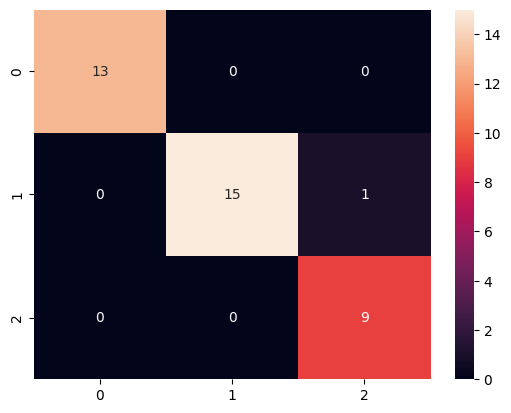

In [8]:
y_pred = qnn.predict(x_test)
from scipy.special import softmax
from sklearn.metrics import log_loss, confusion_matrix
import seaborn as sns

y_pred_sm = softmax(y_pred, axis=1)
log = log_loss(y_test, y_pred_sm)
cm = confusion_matrix(y_test, y_pred.argmax(axis=1))
# log = log_loss(y_test,y_pred)
sns.heatmap(cm, annot=True)
print(log)